In [1]:
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import tensorflow as tf
from scipy.linalg import block_diag

//anaconda/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


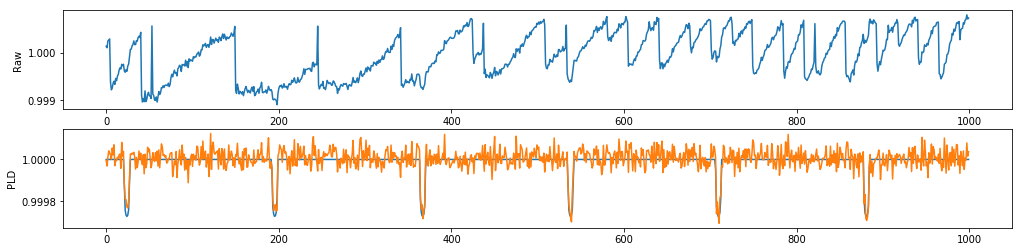

In [2]:
# Load some fake data
txtdat = np.loadtxt("data.txt")
fpix = txtdat[:,:49]
truth = txtdat[:,49]
fpld = txtdat[:,50]

# Plot it
fig, ax = pl.subplots(2, figsize=(17, 4));
ax[0].plot(np.sum(fpix, axis=1));
ax[0].set_ylabel('Raw');
ax[1].plot(fpld);
ax[1].plot(truth);
ax[1].set_ylabel('PLD');

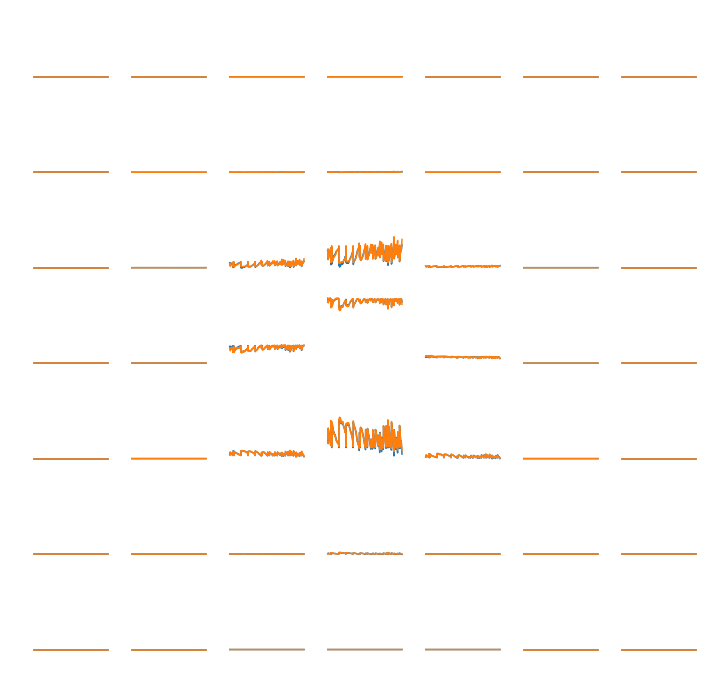

In [11]:
# Number of regressors
K = 3

# Initialize S to the identity matrix
# NOTE: THIS IS **INSANE** -- we get a good model even when the S matrix
# is garbage, meaning there's still a degeneracy in the problem; the systematics
# matrices are clearly picking up the slack
S_diag_init = 1 + np.random.randn(fpix.shape[0])
    
# Estimate A with PCA
X = fpix / S_diag_init.reshape(-1, 1)
X -= np.nanmedian(X, axis = 0)
U, _, _ = np.linalg.svd(X)
A_0_init = U[:,:K-1]
    
# Estimate B
A = np.hstack((np.ones(fpix.shape[0]).reshape(-1,1), A_0_init))
ATA = np.dot(A.T, (S_diag_init ** 2)[:,None] * A)
ATF = np.dot(A.T, S_diag_init[:,None] * fpix)
B_init = np.linalg.solve(ATA, ATF)

# Re-estimate A
b1 = B_init[0,:]
BBT = np.dot(B_init[1:], B_init[1:].T)
BFT = np.dot(B_init[1:], (fpix / S_diag_init[:,None] - b1[None,:]).T)
A_0_init = np.linalg.solve(BBT, BFT).T
A_init = np.hstack((np.ones(fpix.shape[0]).reshape(-1,1), A_0_init))

# Plot the initial model
model = S_diag_init[:, None] * np.dot(A_init, B_init)
fig, ax = pl.subplots(7, 7, figsize=(12,12))
fpix_model = model.reshape(-1,7,7)
for i in range(7):
    for j in range(7):
        ax[j,i].plot(fpix_model[:,i,j])
        ax[j,i].plot(fpix.reshape(-1,7,7)[:,i,j])
        ax[j,i].axis('off')
        ax[j,i].set_ylim(-0.1,0.5)

In [12]:
# Tensorflow time!
session = tf.Session()
T = tf.float64

# Declare our matrices
F = tf.constant(fpix, dtype=T)
S_diag = tf.Variable(S_diag_init, dtype=T)
A_0 = tf.Variable(A_0_init, dtype=T)
B = tf.Variable(B_init, dtype=T)
A = tf.concat((tf.ones((fpix.shape[0], 1), dtype=T), A_0), axis=1)

# This is our model
F_model = S_diag[:, None] * tf.matmul(A, B)

# This is our objective function
chi2 = tf.reduce_sum(tf.squared_difference(F, F_model))

# This is our optimizer!
var_list = [S_diag, A_0, B]
opt = tf.train.AdamOptimizer().minimize(chi2, var_list=var_list)

# Run
session.run(tf.global_variables_initializer())

In [17]:
print(session.run(chi2))
for i in range(10000):
    session.run(opt)
print(session.run(chi2))

0.1969738758589234
0.4356514615350732


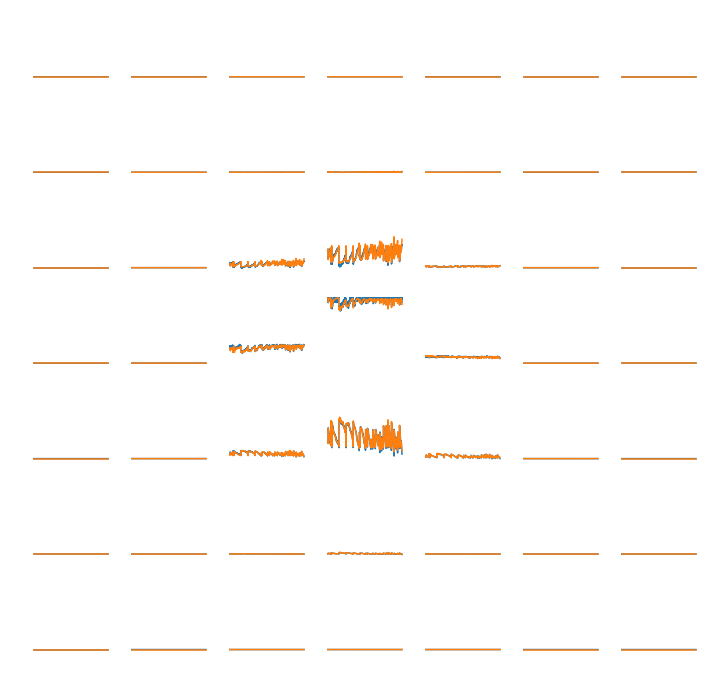

In [18]:
fig, ax = pl.subplots(7, 7, figsize=(12,12))
fpix_model = session.run(F_model).reshape(-1,7,7)
for i in range(7):
    for j in range(7):
        ax[j,i].plot(fpix_model[:,i,j])
        ax[j,i].plot(fpix.reshape(-1,7,7)[:,i,j])
        ax[j,i].axis('off')
        ax[j,i].set_ylim(-0.1,0.5)

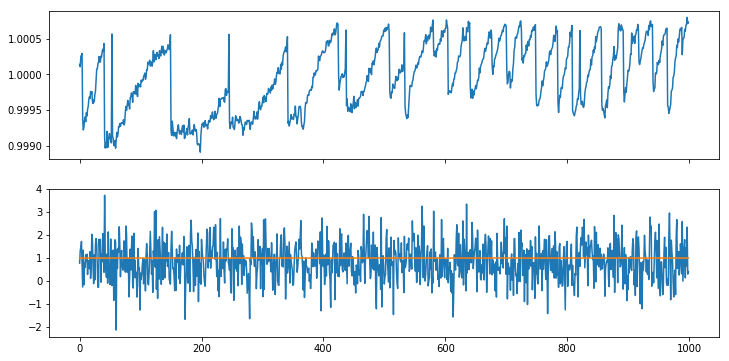

In [19]:
fig, ax = pl.subplots(2, figsize=(12,6), sharex=True)
ax[0].plot(np.sum(fpix, axis=1))
ax[1].plot(session.run(S_diag));
ax[1].plot(truth)